In [1]:
import sys, os, pprint
sys.path.append(os.path.abspath('../'))
import argparse, logging, sys
import ptp.reader
import ptp.ls
import ptp.metrics
import ptp.pktselection
import ptp.kalman
import ptp.frequency
import ptp.window
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
filename   = "../data/serial-20190813-185308.json"

In [3]:
reader = ptp.reader.Reader(filename)
reader.run()
print("Dataset info:")
pprint.pprint(reader.metadata)

Dataset info:
{'fh_traffic': {'bitrate': {'dl': 837120000.0, 'ul': 418560000.0},
                'fs': 7680000.0,
                'iq_size': 24,
                'n_rru_active': 1,
                'n_rru_cfg': 1,
                'n_spf': 64,
                'type': 'inline'},
 'hops': 4,
 'oscillator': 'xo',
 'start_time': '2019-08-13 18:53:08',
 'sync_period': 0.25}


In [4]:
# Message period in nanoseconds
if (reader.metadata is not None and "sync_period" in reader.metadata):
    T_ns = reader.metadata["sync_period"]*1e9
else:
    T_ns = 1e9/4

In [5]:
window_optimizer = ptp.window.Optimizer(reader.data, T_ns)
window_optimizer.process('all', file=filename,
                         plot=True, fine_pass=False, force=False)
window_optimizer.save()
est_op    = window_optimizer.est_op
N_ls      = est_op["ls"]["N_best"]             # LS
N_movavg  = est_op["sample-average"]["N_best"] # Moving average
N_median  = est_op["sample-median"]["N_best"]  # Sample-median
N_min     = est_op["sample-min"]["N_best"]     # Sample-minimum
N_max     = est_op["sample-max"]["N_best"]     # Sample-maximum
N_mode    = est_op["sample-mode"]["N_best"]    # Sample-mode
N_ewma    = est_op["sample-ewma"]["N_best"]    # EWMA

print("Tuned window lengths:")
for i in est_op:
    print("%20s: %d" %(i, est_op[i]["N_best"]))

Tuned window lengths:
                  ls: 32
      sample-average: 8
         sample-ewma: 8
       sample-median: 4
          sample-min: 32
          sample-max: 8
         sample-mode: 8


In [6]:
# Raw frequency estimations (differentiation of raw time offset measurements)
freq_delta     = 64
freq_estimator = ptp.frequency.Estimator(reader.data, delta=freq_delta)
freq_estimator.set_truth(delta=freq_delta)
freq_estimator.optimize()
freq_estimator.process()

In [7]:
# Estimate time offset drifts due to frequency offset
freq_estimator.estimate_drift()

In [8]:
# Least-squares estimator
ls = ptp.ls.Ls(N_ls, reader.data, T_ns)
ls.process("eff")

In [9]:
# Kalman
# kalman = ptp.kalman.Kalman(reader.data, T_ns/1e9)
kalman = ptp.kalman.Kalman(reader.data, T_ns/1e9,
                           trans_cov = [[1, 0], [0, 1e-2]],
                           obs_cov = [[1e4, 0], [0, 1e2]])
kalman.process()

In [10]:
pkts = ptp.pktselection.PktSelection(N_movavg, reader.data)

In [11]:
# Moving average
pkts.process("average", avg_impl="recursive")

In [12]:
# Sample-median
pkts.set_window_len(N_median)
pkts.process("median")

In [13]:
# Sample-minimum
pkts.set_window_len(N_min)
pkts.process("min")

In [14]:
# Sample-maximum
pkts.set_window_len(N_max)
pkts.process("max")

In [15]:
# Exponentially weighted moving average
pkts.set_window_len(N_ewma)
pkts.process("ewma")

In [16]:
# Sample-mode
pkts.set_window_len(N_mode)
pkts.process("mode")

In [17]:
# PTP analyser
analyser = ptp.metrics.Analyser(reader.data)

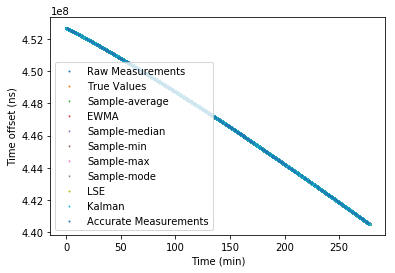

In [18]:
analyser.plot_toffset_vs_time(save=False)

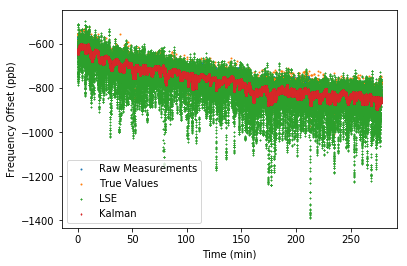

In [19]:
analyser.plot_foffset_vs_time(save=False)

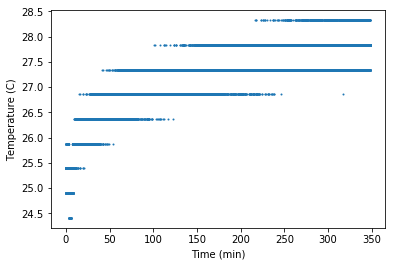

In [20]:
analyser.plot_temperature(save=False)

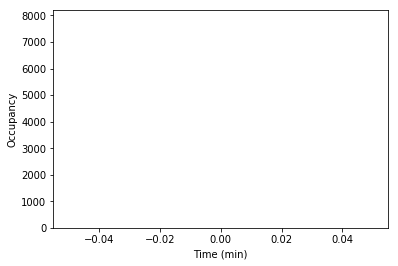

In [21]:
analyser.plot_occupancy(save=False)

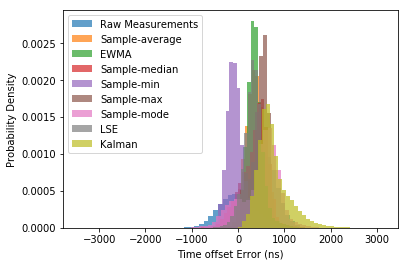

In [22]:
analyser.plot_toffset_err_hist(save=False)

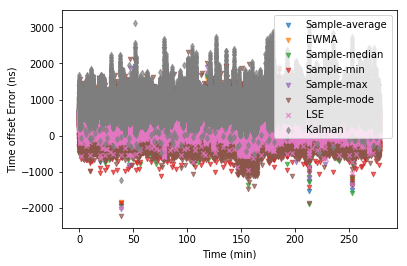

In [23]:
analyser.plot_toffset_err_vs_time(show_raw = False, save=False)

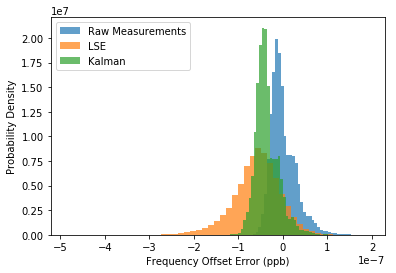

In [24]:
analyser.plot_foffset_err_hist(save=False)

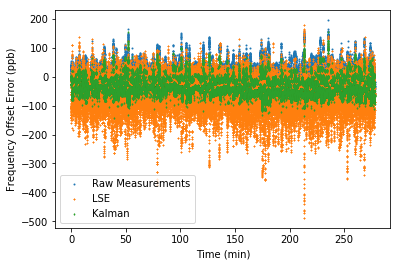

In [25]:
analyser.plot_foffset_err_vs_time(save=False)

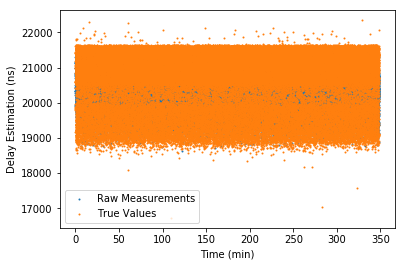

In [26]:
analyser.plot_delay_vs_time(save=False)

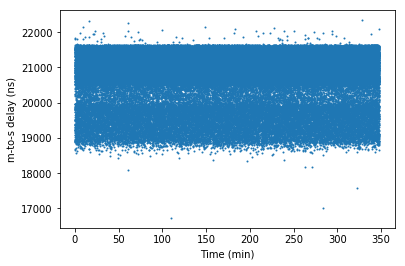

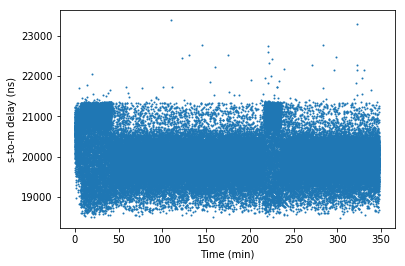

In [27]:
analyser.plot_delay_vs_time(split=True, save=False)

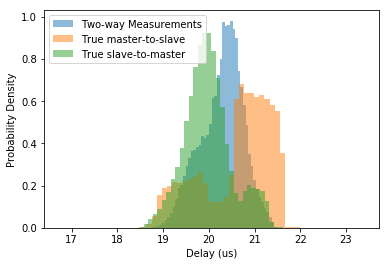

In [28]:
analyser.plot_delay_hist(n_bins=50, save=False)

/Users/igorfreire/.virtualenvs/ptp-sim/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


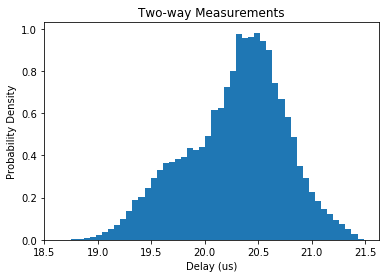

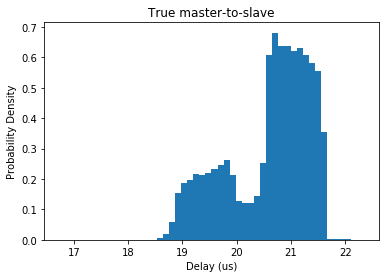

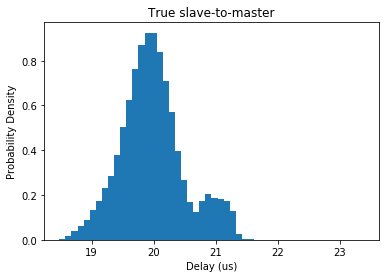

In [29]:
analyser.plot_delay_hist(split=True, n_bins=50, save=False)

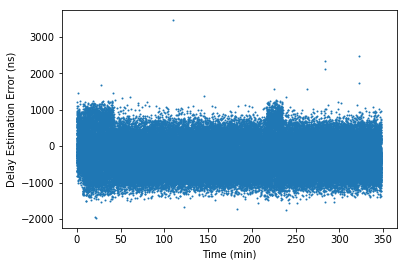

In [30]:
analyser.plot_delay_est_err_vs_time(save=False)

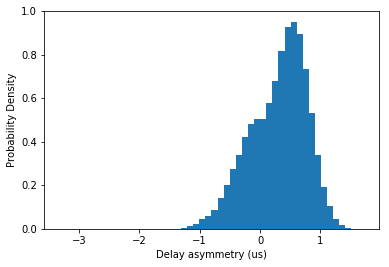

In [31]:
analyser.plot_delay_asym_hist(n_bins=50, save=False)

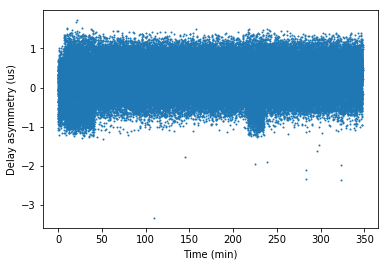

In [32]:
analyser.plot_delay_asym_vs_time(save=False)

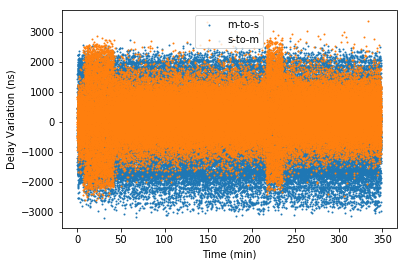

In [33]:
analyser.plot_pdv_vs_time(save=False)

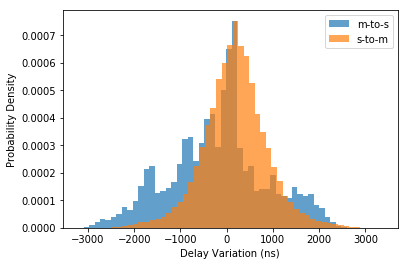

In [34]:
analyser.plot_pdv_hist(save=False)

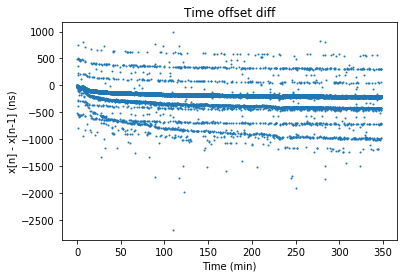

In [35]:
analyser.plot_toffset_diff_vs_time(save=False)

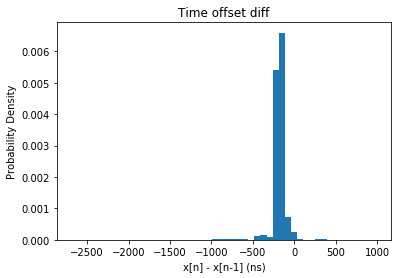

In [36]:
analyser.plot_toffset_diff_hist(save=False)

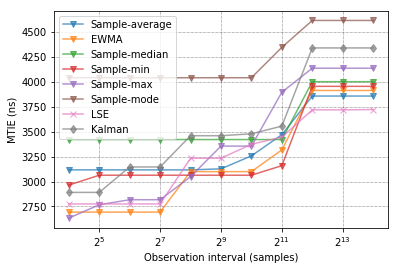

In [37]:
analyser.plot_mtie(show_raw = False, save=False)

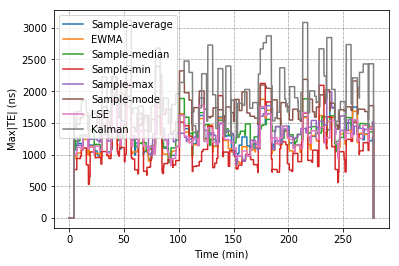

In [38]:
analyser.plot_max_te(show_raw=False, window_len = 1000, save=False)

In [39]:
analyser.ptp_exchanges_per_sec(save=False)

Average no. of PTP exchanges per second: 3.692552


3.6925524590566385

In [40]:
analyser.delay_asymmetry(save=False)


Delay asymmetry analysis:

Metric 	      m-to-s	      s-to-m	   asymmetry
Average	 20597.40 ns	 19988.54 ns	   304.43 ns
Minimum	 16732.00 ns	 18481.00 ns	  -874.50 ns
Maximum	 22338.00 ns	 23385.00 ns	  -523.50 ns
Median	 20800.00 ns	 19952.00 ns	   424.00 ns


304.4277025625065

In [41]:
analyser.toffset_err_stats(save=False)


Time offset estimation error statistics:

[         x_est] Mean:  334.29 ns	Sdev:  449.65 ns
[x_pkts_average] Mean:  335.12 ns	Sdev:  209.50 ns
[   x_pkts_ewma] Mean:  335.97 ns	Sdev:  182.04 ns
[ x_pkts_median] Mean:  362.89 ns	Sdev:  287.25 ns
[    x_pkts_min] Mean:  -21.58 ns	Sdev:  247.31 ns
[    x_pkts_max] Mean:  466.99 ns	Sdev:  209.35 ns
[   x_pkts_mode] Mean:  480.13 ns	Sdev:  409.03 ns
[      x_ls_eff] Mean:  334.35 ns	Sdev:  212.30 ns
[          x_kf] Mean:  744.56 ns	Sdev:  342.18 ns


In [42]:
analyser.foffset_err_stats(save=False)


Frequency offset estimation error statistics:

[         y_est] Mean:  2.0681 ppb	Sdev:  28.4875 ppb
[      y_ls_eff] Mean: -55.7403 ppb	Sdev:  53.4458 ppb
[          y_kf] Mean:  59.2049 ppb	Sdev:  1967.0593 ppb
